# This is a notebook for generating data only

This is how much space the figure will take up on letter paper


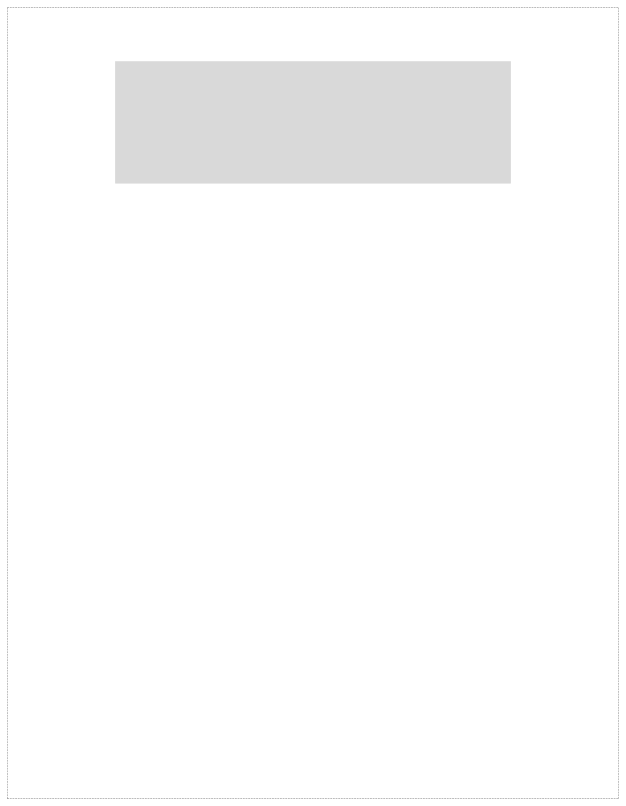

In [33]:
__PRODUCTION__ = 0
__NAME__       = 'optimization'
__WIDTH__      = 5.5  # NeurIPS 2021 text box width
__HEIGHT__     = 1.7

if __PRODUCTION__:
    from mplmagic import pgf
else:
    from mplmagic import svg

from mplmagic.util import SuperFigure, SuperAxes, size_hint
import matplotlib.pyplot as plt

print('This is how much space the figure will take up on letter paper')
size_hint(__WIDTH__, __HEIGHT__, margin_left=0.5 * (8.5 - __WIDTH__));

In [34]:
import matplotlib.pyplot as plt
import functools
import numpy as np
from scipy.ndimage import gaussian_filter1d
from scipy.spatial.distance import cdist
import torch
import torch.nn.functional as F
from torch import optim
import pickle

from symfac.experimental import RBFExpansionPlus
from symfac.experimental import RBFExpansionMiniBatchPlus

/home/symfac/.local/lib/python3.8/site-packages/matplotlib/textpath.py:90: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=LOAD_NO_HINTING)
/home/symfac/.local/lib/python3.8/site-packages/matplotlib/textpath.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  glyph = font.load_char(ccode, flags=LOAD_NO_HINTING)


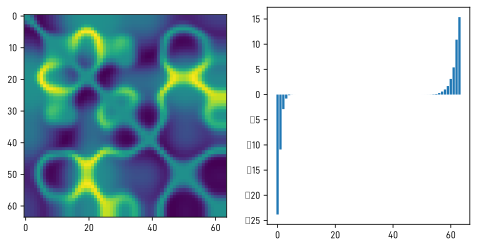

[0.12843, 0.07073, 0.04168, 0.0127, 0.0056, 0.00325, 0.00121, 0.00052, 0.00027]


In [35]:
def rbf(X, Y=None):
    return np.exp(-np.subtract.outer(X, Y if Y is not None else X)**2)

n = 64

np.random.seed(78963)
u = 5 * np.random.randn(n)
v = 4 * np.random.randn(n)
U = gaussian_filter1d(u, 3., order=0)
V = gaussian_filter1d(v, 6., order=0)

K = rbf(U) - rbf(V)
Kt = torch.tensor(K, dtype=torch.float32)

fig, axs = plt.subplots(1, 2, figsize=(8, 4))

axs[0].imshow(K)
axs[1].bar(np.arange(n), np.linalg.eigvalsh(K))
plt.show()

U, S, V = np.linalg.svd(K)
svd_K = []
for k in range(1, 10):
    truncation = (U[:, :k] * S[None, :k]) @ V[:k, :]
    svd_K.append(round(float(F.mse_loss(torch.tensor(truncation), torch.tensor(K))), 5))
print(svd_K)

In [36]:
optimizers = ['SGD', 'Adam', 'Adadelta', 'Adagrad', 'RMSprop', 'ASGD', 'AdamW']

In [37]:
for opt in optimizers:
    fac = RBFExpansionPlus(
        k=2,
        batch_size=128,
        algorithm=opt,
        max_steps=10000
    ).fith(
        Kt
    )
    
    print(fac.report.loss_best.min())
    
    fac.to_pickle(f'data/optimization-gradient-descent-{opt}.pickle')

  0%|          | 0/10000 [00:00<?, ?it/s]

tensor(0.0723)


  0%|          | 0/10000 [00:00<?, ?it/s]

tensor(0.0455)


  0%|          | 0/10000 [00:00<?, ?it/s]

tensor(0.0529)


  0%|          | 0/10000 [00:00<?, ?it/s]

tensor(0.0413)


  0%|          | 0/10000 [00:00<?, ?it/s]

tensor(0.0814)


  0%|          | 0/10000 [00:00<?, ?it/s]

tensor(0.0687)


100%|██████████| 10000/10000 [00:20<00:00, 493.61it/s]

tensor(0.0455)


In [39]:
for opt in optimizers:
    fac_mini = RBFExpansionMiniBatchPlus(
        k=k,
        mini_batch_size=4 * Kt.shape[0],
        algorithm=opt,
        batch_size=128,
        max_steps=10000,
        lr=0.05,
        mini_batch_by='elements'
    )
    fac_mini.fit_custom(
        Kt,
        f=lambda rbf, u, a, b:
            torch.sum(
                rbf(u[..., :, None, :] - u[..., None, :, :]) *
                a[..., None, None, :],
                dim=-1
            ) + b[..., None, None],
        f_minibatch=lambda rbf, i, j, u, a, b:
            torch.sum(
                rbf(u[..., i, :] - u[..., j, :]) * a[..., None, :],
            dim=-1
        ) + b[..., None],
        u=0.001 * fac_mini.randn(fac_mini.batch_size, Kt.shape[0], fac_mini.k),
        a=fac_mini.randn(fac_mini.batch_size, fac_mini.k),
        b=fac_mini.randn(fac_mini.batch_size)
    )
    print(fac_mini.report.loss_best.min())
    fac_mini.to_pickle(f'data/optimization-stochastic-gradient-descent-{opt}.pickle')

  0%|          | 0/10000 [00:00<?, ?it/s]

tensor(0.2067)


  0%|          | 0/10000 [00:00<?, ?it/s]

tensor(9.4846e-06)


  0%|          | 0/10000 [00:00<?, ?it/s]

tensor(0.2067)


  0%|          | 0/10000 [00:00<?, ?it/s]

tensor(2.6643e-05)


  0%|          | 0/10000 [00:00<?, ?it/s]

tensor(0.0014)


  0%|          | 0/10000 [00:00<?, ?it/s]

tensor(0.2067)


100%|██████████| 10000/10000 [00:26<00:00, 383.67it/s]

tensor(6.9247e-05)


In [43]:
for zoom in [1.0, 0.1, 0.01,0.001]:
    fac = RBFExpansionPlus(
        k=k,
        algorithm='Adam',
        batch_size=128,
        max_steps=10000
    )
    fac.fith(
        Kt,
        u0=zoom * fac_mini.randn(fac_mini.batch_size, Kt.shape[0], fac_mini.k),
        a0=fac_mini.randn(fac_mini.batch_size, fac_mini.k),
        b0=fac_mini.randn(fac_mini.batch_size)
    )
    print(fac.report.loss_best.min())
    fac.to_pickle(f'data/optimization-GD-zoom-{zoom}.pickle')

  0%|          | 0/10000 [00:00<?, ?it/s]

tensor(0.0046)


  0%|          | 0/10000 [00:00<?, ?it/s]

tensor(2.5931e-06)


  0%|          | 0/10000 [00:00<?, ?it/s]

tensor(5.6546e-07)


100%|██████████| 10000/10000 [00:28<00:00, 352.50it/s]

tensor(4.2225e-08)


In [44]:
for zoom in [1.0, 0.1, 0.01,0.001]:
    fac_mini = RBFExpansionMiniBatchPlus(
        k=k,
        mini_batch_size=4 * Kt.shape[0],
        algorithm='Adam',
        batch_size=128,
        max_steps=10000,
        lr=0.05,
        mini_batch_by='elements'
    )
    fac_mini.fit_custom(
        Kt,
        f=lambda rbf, u, a, b:
            torch.sum(
                rbf(u[..., :, None, :] - u[..., None, :, :]) *
                a[..., None, None, :],
                dim=-1
            ) + b[..., None, None],
        f_minibatch=lambda rbf, i, j, u, a, b:
            torch.sum(
                rbf(u[..., i, :] - u[..., j, :]) * a[..., None, :],
            dim=-1
        ) + b[..., None],
        u=zoom * fac_mini.randn(fac_mini.batch_size, Kt.shape[0], fac_mini.k),
        a=fac_mini.randn(fac_mini.batch_size, fac_mini.k),
        b=fac_mini.randn(fac_mini.batch_size)
    )
    print(fac_mini.report.loss_best.min())
    fac_mini.to_pickle(f'data/optimization-SGD-zoom-{zoom}.pickle')

  0%|          | 0/10000 [00:00<?, ?it/s]

tensor(0.0062)


  0%|          | 0/10000 [00:00<?, ?it/s]

tensor(1.5087e-05)


  0%|          | 0/10000 [00:00<?, ?it/s]

tensor(3.6801e-06)


100%|██████████| 10000/10000 [00:20<00:00, 494.91it/s]

tensor(3.2804e-05)


END
---